Download the necessary libraries & import data.

Link to data - https://raw.githubusercontent.com/DataSlingers/clustRviz/master/data/authors.rda

In [498]:
%pip install umap-learn --quiet
%pip install adjustText --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [499]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import FastICA, NMF, KernelPCA, PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import SpectralEmbedding
import seaborn as sns
import umap

from adjustText import adjust_text

In [500]:
df = pd.read_csv('authors.csv').rename(columns = {'Unnamed: 0': 'Author'})
df

,Author,a,all,also,an,and,any,are,as,at,...,were,what,when,which,who,will,with,would,your,BookID
0,Austen,46,12,0,3,66,9,4,16,13,...,11,7,5,6,8,4,9,1,0,1
1,Austen,35,10,0,7,44,4,3,18,16,...,13,5,7,7,3,5,14,8,0,1
2,Austen,46,2,0,3,40,1,13,11,9,...,6,10,4,6,4,5,15,3,9,1
3,Austen,40,7,0,4,64,3,3,20,13,...,10,3,6,10,5,3,22,4,3,1
4,Austen,29,5,0,6,52,5,14,17,6,...,5,8,4,13,2,4,21,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,Shakespeare,32,4,0,6,33,0,7,8,4,...,1,13,2,3,3,11,17,5,10,12
837,Shakespeare,16,5,0,5,49,1,6,10,3,...,1,6,5,6,0,11,20,2,7,12
838,Shakespeare,22,15,0,3,48,0,9,10,2,...,0,16,2,2,0,12,15,1,10,12
839,Shakespeare,25,4,0,8,59,3,6,7,3,...,4,11,2,2,2,22,23,4,5,12


In [501]:
df.columns # some words have a period. 

Index(['Author', 'a', 'all', 'also', 'an', 'and', 'any', 'are', 'as', 'at',
       'be', 'been', 'but', 'by', 'can', 'do', 'down', 'even', 'every', 'for.',
       'from', 'had', 'has', 'have', 'her', 'his', 'if.', 'in.', 'into', 'is',
       'it', 'its', 'may', 'more', 'must', 'my', 'no', 'not', 'now', 'of',
       'on', 'one', 'only', 'or', 'our', 'should', 'so', 'some', 'such',
       'than', 'that', 'the', 'their', 'then', 'there', 'things', 'this', 'to',
       'up', 'upon', 'was', 'were', 'what', 'when', 'which', 'who', 'will',
       'with', 'would', 'your', 'BookID'],
      dtype='object')

In [502]:
book_id = df['Author']
book_id.value_counts() # 4 different books ; w/ 317 - Austen, ..., 55 - Milton.
# df[['Author','BookID']].groupby('Author').value_counts()

Author
Austen         317
London         296
Shakespeare    173
Milton          55
Name: count, dtype: int64

- Unsupervised learning: drop columns ['Authors', 'BookID'] and determine patterns with words across chapters using unsupervised learning methods.

- We will later come back to these labels we dropped to validate our results.

- Note, a row represents a book chapter with each column representing the word counts of key words in that chapter.

In [503]:
X = df.copy().drop(['Author','BookID'], axis=1)
X

,a,all,also,an,and,any,are,as,at,be,...,was,were,what,when,which,who,will,with,would,your
0,46,12,0,3,66,9,4,16,13,13,...,40,11,7,5,6,8,4,9,1,0
1,35,10,0,7,44,4,3,18,16,9,...,27,13,5,7,7,3,5,14,8,0
2,46,2,0,3,40,1,13,11,9,23,...,24,6,10,4,6,4,5,15,3,9
3,40,7,0,4,64,3,3,20,13,20,...,26,10,3,6,10,5,3,22,4,3
4,29,5,0,6,52,5,14,17,6,16,...,23,5,8,4,13,2,4,21,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,32,4,0,6,33,0,7,8,4,18,...,0,1,13,2,3,3,11,17,5,10
837,16,5,0,5,49,1,6,10,3,24,...,1,1,6,5,6,0,11,20,2,7
838,22,15,0,3,48,0,9,10,2,13,...,4,0,16,2,2,0,12,15,1,10
839,25,4,0,8,59,3,6,7,3,13,...,3,4,11,2,2,2,22,23,4,5


## PCA

### PCA on Observations = Book Chapters

Each observation (point) is a book chapter.

- Using PCA to reduce high-dimensional word frequency data to 2D: PC1 vs PC2.

- The color (hue) is the true author (used only for validation, not in PCA itself).

- The plot helps explore clustering structure among chapters based on word usage.

- This visualization helps show how different writing styles or vocabularies might naturally separate across authors in an unsupervised way.

In [504]:
# Center the features
scaler = StandardScaler(with_std=False) #not scaling only centering
X_centered = scaler.fit_transform(X)

# Perform PCA on scaled data
pca = PCA()
pca_result = pca.fit_transform(X_centered)

pca_df = pd.DataFrame(pca_result)
cols = [f'PC{j+1}' for j in range(pca_df.shape[1])]
pca_df = pca_df.rename(columns = {i:cols[i] for i in range(pca_df.shape[1])})
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
0,-2.265044,43.499301,5.196950,-2.333575,23.359407,22.309224,13.585777,-0.891477,-2.178907,0.062718,...,-2.043904,-3.175850,1.578725,-2.575981,1.463553,-1.107755,-0.341962,2.639943,3.214014,-0.594109
1,-2.604648,25.086417,-9.488717,7.748273,19.244916,1.052493,6.765152,3.650037,-0.746511,-1.753312,...,-2.269775,0.991903,0.013898,1.037391,-1.077602,0.044514,-1.312650,0.800142,0.183083,-0.194564
2,-33.199533,8.667765,-14.833418,3.971572,-6.913595,4.173856,7.094662,-11.728066,1.002140,-4.270366,...,-2.055041,0.864406,-2.179206,2.564626,-3.672920,0.798756,-0.664101,-1.319190,-0.493611,0.165242
3,8.098653,21.760546,6.962558,6.683136,15.262020,7.640936,11.974431,-5.748289,-1.011280,-4.502115,...,0.590874,0.830834,-1.969229,0.937902,-3.603491,-1.244561,1.283435,-0.912942,-0.271062,-0.743841
4,10.031814,6.801164,0.035520,22.731646,10.465248,-5.248171,7.489147,-6.171808,-9.885234,-14.616535,...,1.616164,2.706626,-0.708168,-1.272716,-0.278721,-1.525001,1.746847,-1.004067,-1.272581,-0.229321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,-64.400961,-28.132705,-21.267908,0.131106,-0.337083,12.068621,-5.848328,3.920184,-7.233151,0.239586,...,-0.089364,-0.674634,-1.165301,-0.470178,-1.348415,-0.240363,0.167233,0.514576,-0.123753,-0.036760
837,-58.313001,-23.417273,4.887866,2.462693,-1.275957,-2.603434,-11.452006,4.745220,7.397146,-1.948260,...,-0.264725,-1.237238,-0.170168,1.335993,0.455795,0.942986,-0.266152,-2.256417,-0.182997,-0.021365
838,-47.898865,-31.938566,-7.364020,-9.133520,10.442357,14.851150,-10.872174,10.228351,-5.141056,3.876664,...,0.938558,1.771321,1.542836,-1.795202,1.242780,2.648138,-0.017259,-2.002290,0.787364,0.071339
839,-39.844905,-29.936659,0.614003,-2.261258,5.007836,14.369278,-3.165040,3.620264,1.479972,2.361646,...,-0.011889,1.010582,1.514307,-0.011713,1.135751,0.803847,-0.028491,-0.803976,-1.307802,-0.026705


Let us visualize some of these high variance patterns.

In [505]:
df2, pca_df_with_author = df.copy(), pca_df.copy()
authors = list(df2['Author'].unique())
authors_encoded = {authors[i]:i for i in range(len(authors))}
df2['Author_encoded'] = df2['Author'].apply(lambda x: authors_encoded[x])
pca_df_with_author['Author'] = df2['Author']


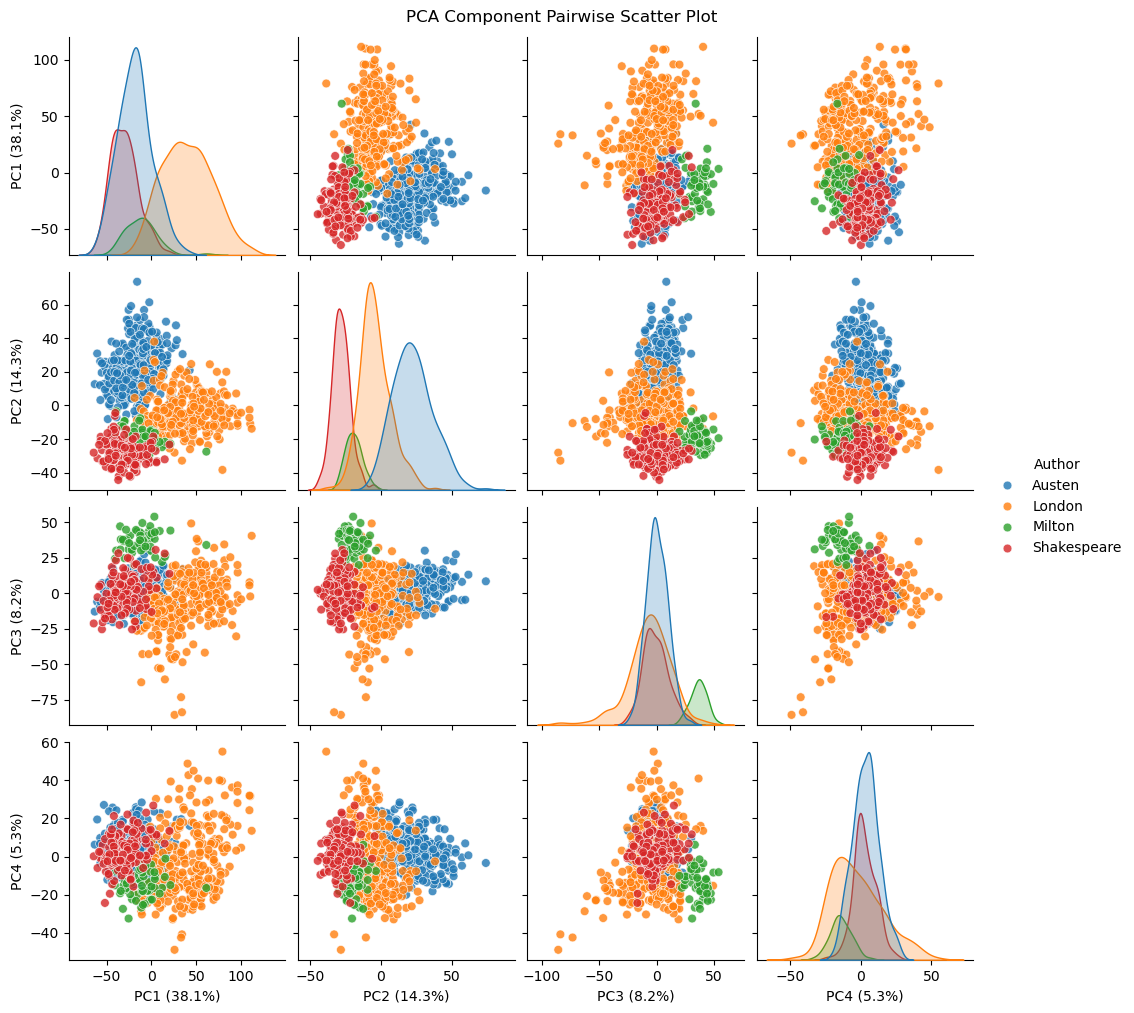

In [506]:
n = 4
pca_subset = pca_df_with_author[[f'PC{i+1}' for i in range(n)] + ['Author']] # Extract top-n PCs with author labels
explained = pca.explained_variance_ratio_[:n] * 100
pca_subset.columns = [f'PC{i+1} ({explained[i]:.1f}%)' for i in range(n)] + ['Author']

sns.pairplot(pca_subset, hue='Author', palette='tab10', corner=False, plot_kws={'alpha':0.8, 's':40})
plt.suptitle('PCA Component Pairwise Scatter Plot', y=1.01);


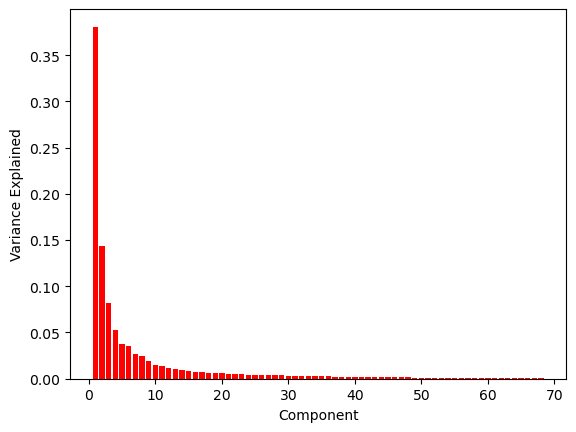

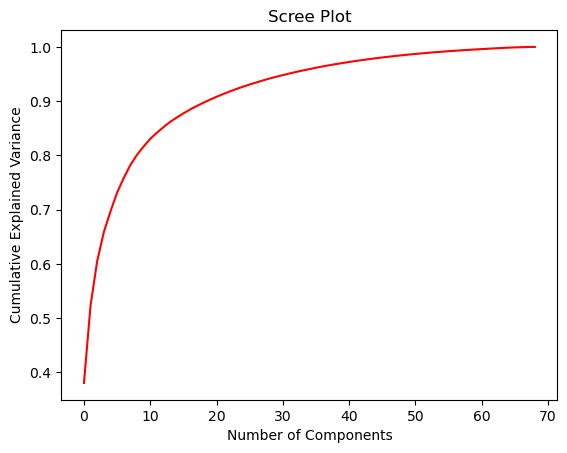

In [507]:
# Variance Explained Plot
plt.bar(np.arange(1, pca_df.shape[1]),pca.explained_variance_ratio_[0:pca_df.shape[1]-1], color = 'red')
plt.xlabel('Component')
plt.ylabel('Variance Explained')
plt.show()

# Screeplot
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'red')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

PCA is nested and ordered meaning the most variance explained is given by PC1, and the second most is PC2 and so on.

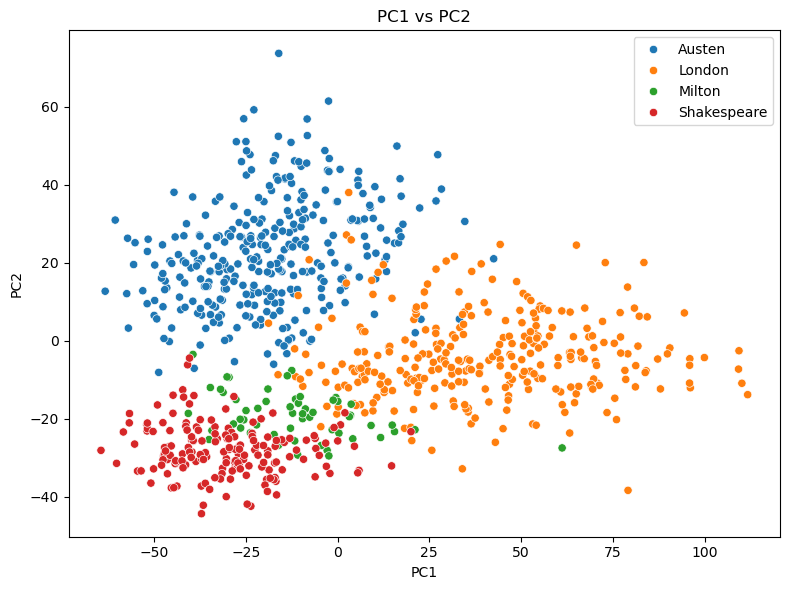

In [508]:
# Best Plot for PCA; LARGEST VARIANCE EXPLAINED
x, y = 'PC1', 'PC2' #adjust here
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_with_author, x=x, y=y, hue='Author', palette='tab10', alpha=1)
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{x} vs {y}')
plt.legend(loc='upper right')
plt.tight_layout();


### PCA on Features = Words

To do this we must transpose our dataframe and then apply the same methods as we have already done.

In [509]:
X_transpose = X.T
X_transpose = X_transpose.rename(columns = {i:f'Chapter{i}' for i in range(X_transpose.shape[1])})
X_transpose

,Chapter0,Chapter1,Chapter2,Chapter3,Chapter4,Chapter5,Chapter6,Chapter7,Chapter8,Chapter9,...,Chapter831,Chapter832,Chapter833,Chapter834,Chapter835,Chapter836,Chapter837,Chapter838,Chapter839,Chapter840
a,46,35,46,40,29,27,34,38,34,54,...,46,48,39,22,28,32,16,22,25,26
all,12,10,2,7,5,8,8,6,12,8,...,4,2,5,13,7,4,5,15,4,4
also,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
an,3,7,3,4,6,3,15,2,5,6,...,3,9,10,5,7,6,5,3,8,2
and,66,44,40,64,52,42,44,67,50,44,...,43,45,38,47,45,33,49,48,59,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
who,8,3,4,5,2,6,4,6,1,3,...,1,0,2,4,2,3,0,0,2,3
will,4,5,5,3,4,3,9,7,2,5,...,7,10,8,9,7,11,11,12,22,11
with,9,14,15,22,21,18,11,15,13,15,...,18,11,26,12,8,17,20,15,23,19
would,1,8,3,4,10,4,6,3,12,6,...,2,6,2,6,3,5,2,1,4,0


In [510]:
# Center the features
scaler = StandardScaler(with_std=False) #not scaling only centering
X_centered = scaler.fit_transform(X_transpose)

# Perform PCA on scaled data
pca = PCA()
pca_result = pca.fit_transform(X_centered)

pca_df = pd.DataFrame(pca_result)
pca_df
cols = [f'PC{j+1}' for j in range(pca_df.shape[1])]
pca_df = pca_df.rename(columns = {i:cols[i] for i in range(pca_df.shape[1])})
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
0,586.050387,50.163435,35.008000,168.930205,-130.584023,73.261875,-29.813398,168.671326,-61.911809,21.158393,...,-0.028808,0.113269,1.092135,-0.201903,0.262726,1.107467,0.267015,-0.722587,0.179808,-1.770472e-13
1,-37.056676,-10.180601,-16.920965,-30.520113,3.085172,20.370336,20.955037,-0.813120,17.153739,30.872873,...,0.383836,-1.896502,-0.728495,-0.148027,0.496899,0.136251,-1.388524,0.477743,0.099273,-1.770472e-13
2,-275.839489,-61.225551,6.542485,-19.703686,9.328641,-2.643178,-3.371529,0.617304,0.584185,6.107842,...,0.712761,1.037531,0.474338,0.035060,0.788778,3.461856,4.778726,-4.906359,21.112972,-1.770472e-13
3,-104.140778,-88.729476,66.332678,99.893861,-71.260129,68.939655,106.172522,50.921177,67.834993,33.808069,...,0.975580,-0.991620,0.662421,0.262686,-0.909937,0.085531,-0.275755,-0.024427,0.196647,-1.770472e-13
4,1382.039964,83.594605,-205.254255,-236.146710,-59.203247,104.908651,-128.422484,0.908687,-10.144823,34.286019,...,0.052213,0.191897,-0.085089,0.037987,-0.020694,0.412064,-0.036710,0.047517,0.012894,-1.770472e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,-196.515788,-39.201310,-7.834830,-34.170276,11.928960,-1.666978,2.402290,-0.833140,-4.003598,14.434970,...,4.150651,-6.933739,-2.684091,-1.327385,-3.544767,0.868296,-2.969765,2.022023,-1.157411,-1.770472e-13
65,-163.405364,20.899231,-65.458337,30.432454,19.277051,8.046761,-2.666711,-30.745087,-22.235191,-5.186976,...,-1.147283,0.539559,-0.894122,0.218372,-2.533878,-0.526107,0.265318,-0.601183,-0.176481,-1.770472e-13
66,117.773657,29.506734,-56.978315,-56.128898,-25.663028,42.057283,43.679642,17.993353,18.300923,-6.102379,...,0.004423,-0.449697,0.140373,0.345507,0.482392,-0.165196,-0.455603,-0.195493,0.008405,-1.770472e-13
67,-155.766334,15.342778,31.947285,8.771575,5.470745,-8.483044,-16.765466,-16.416750,-17.988385,8.851434,...,1.218601,-0.257285,0.432577,0.955203,-1.526013,-0.270182,0.440711,0.786147,-0.240139,-1.770472e-13


The issue here is $ p >> n $ and so pca_df is rank defficient.  It is tricky to validate.

In [511]:
df4 = df.copy()
df4 = df4.drop('BookID',axis=1).groupby('Author').sum().T
df4.columns.name = None 
df4 = df4.reset_index(drop=False).rename(columns = {'index':'Words'})
df4['Cumulative'] = df4.iloc[:,1:].sum(axis = 1)
for author in ['Austen','London','Milton','Shakespeare']:
    df4[f'{author} %'] = df4[author] / df4['Cumulative']

# encode the label to most frequent word usage
code = {i:author for i, author in zip(list(range(4)),['Austen','London','Milton','Shakespeare'])}
perc = df4.iloc[:,-4:].to_numpy()
max_indices = np.argmax(perc, axis=1)
authors = [code[i] for i in list(max_indices)]
df4['Likely Author'] = authors
df4

,Words,Austen,London,Milton,Shakespeare,Cumulative,Austen %,London %,Milton %,Shakespeare %,Likely Author
0,a,9902,10351,670,4841,25764,0.384335,0.401762,0.026005,0.187898,London
1,all,2752,2695,813,1287,7547,0.364648,0.357096,0.107725,0.170531,Austen
2,also,83,226,47,18,374,0.221925,0.604278,0.125668,0.048128,London
3,an,1650,3230,37,641,5558,0.296869,0.581144,0.006657,0.115329,London
4,and,16373,18668,4009,8945,47995,0.341140,0.388957,0.083530,0.186374,London
...,...,...,...,...,...,...,...,...,...,...,...
64,who,1047,904,365,444,2760,0.379348,0.327536,0.132246,0.160870,Austen
65,will,1778,719,211,1554,4262,0.417175,0.168700,0.049507,0.364618,Austen
66,with,4426,3980,1306,2532,12244,0.361483,0.325057,0.106664,0.206795,Austen
67,would,2427,968,75,709,4179,0.580761,0.231634,0.017947,0.169658,Austen


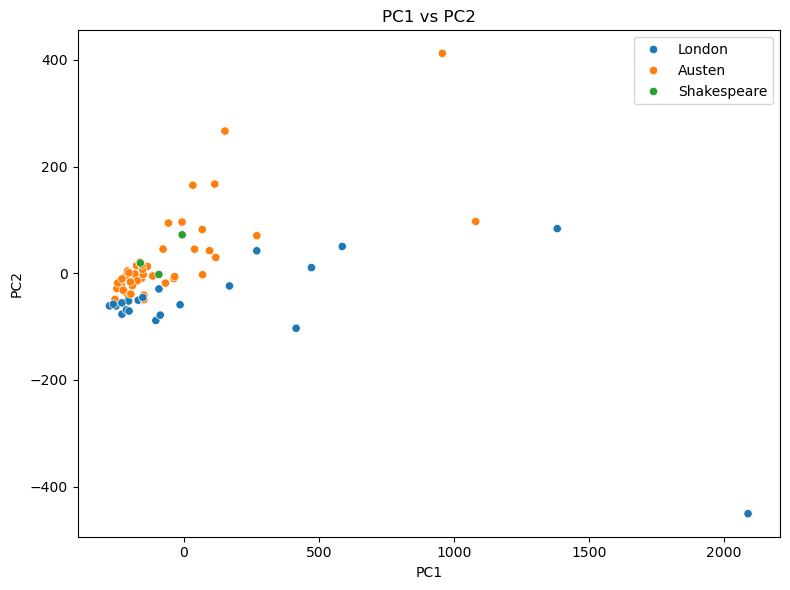

In [512]:
pca_df['Likely Author'] = df4['Likely Author']

# Best Plot for PCA; LARGEST VARIANCE EXPLAINED
x, y = 'PC1', 'PC2' #adjust here
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x=x, y=y, hue='Likely Author', palette='tab10', alpha=1)
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{x} vs {y}')
plt.legend(loc='upper right')
plt.tight_layout();

In [513]:
df2, pca_df_with_author = df.copy(), pca_df.copy()
authors = list(df2['Author'].unique())
authors_encoded = {authors[i]:i for i in range(len(authors))}
df2['Author_encoded'] = df2['Author'].apply(lambda x: authors_encoded[x])
pca_df_with_author['Author'] = df2['Author']

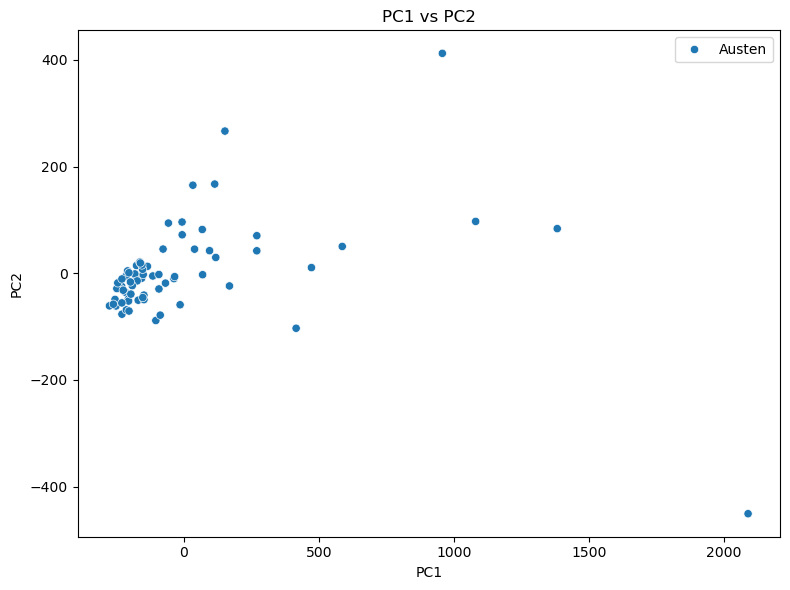

In [514]:
# Best Plot for PCA; LARGEST VARIANCE EXPLAINED
x, y = 'PC1', 'PC2' #adjust here
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_with_author, x=x, y=y, hue='Author', palette='tab10', alpha=1)
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{x} vs {y}')
plt.legend(loc='upper right')
plt.tight_layout();